In [3]:
import sys
sys.path.append('../')

In [22]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.utils as tvu

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from models import *
from data import *
from utils import *

In [19]:
use_cuda = True

In [8]:
dtype = torch.cuda.FloatTensor
device = torch.device("cuda")
torch.cuda.set_device(1)
print('GPU')

GPU


In [7]:
# settings
encoder_size = 1024
decoder_size = 1024
latent_size = 128
out_channels = 3
in_channels = 3
channels_gen = 64

In [12]:
loader = CelebALoader('/ndata/CelebA', 32, 0.2, True, True, True)
train_loader = loader.train_loader
test_loader = loader.test_loader

In [14]:
E = DCGAN2_Encoder([3, 64, 64], out_channels, encoder_size, latent_size).type(dtype)
h_conv_outsize = E.H_conv_out
G = DCGAN2_Generator(h_conv_outsize, out_channels, channels_gen, decoder_size, latent_size).type(dtype)
D = DCGAN_Discriminator(in_channels).type(dtype)

In [15]:
checkpoint = torch.load('../models/Mar-16-2020_1241_IBN_DCGAN_12_0.0050.pt')

In [16]:
E.load_state_dict(checkpoint['E'])
G.load_state_dict(checkpoint['G'])
D.load_state_dict(checkpoint['D'])

<All keys matched successfully>

#### Testing the generator

In [112]:
z_real = sample_gauss_noise(8, 128)
z_real = z_real.cuda() if use_cuda else z_real
x_hat = G(z_real).cpu().detach()
x_hat = x_hat * 0.5 + 0.5

In [113]:
x_hat.size()

torch.Size([8, 3, 64, 64])

In [114]:
sample = tvu.make_grid(x_hat, normalize=True, scale_each=True)

In [115]:
sample.size()

torch.Size([3, 68, 530])

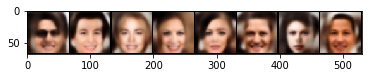

In [116]:
npimg = sample.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

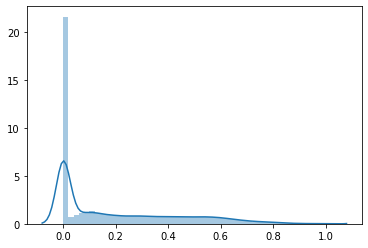

In [72]:
sns.distplot(npimg[2].ravel())

#### Reconstruction example

In [93]:
x, _ = next(iter(test_loader))

In [101]:
n_samples = 8
is_conv = True
img_shape = [3, 64, 64]
n_samples = min((n_samples, x.size(0)))

if is_conv:
    x = x.view(-1, img_shape[0], img_shape[1], img_shape[2])
else:
    x = x.view(x.size(0), -1)
        
x = x.cuda() if use_cuda else x

z_val, _, _ = E(x)
x_hat = G(z_val)
x_hat = x_hat * 0.5 + 0.5

In [102]:
x = x[:n_samples].cpu()
x_hat = x_hat[:n_samples].cpu()

In [103]:
x_hat.size()

torch.Size([8, 3, 64, 64])

In [104]:
grid_x = tvu.make_grid(x.detach().cpu(), normalize=True, scale_each=True)
grid_x_hat = tvu.make_grid(x_hat.detach().cpu(), normalize=True, scale_each=True)

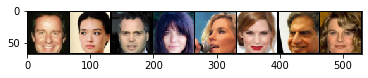

In [105]:
npimg = grid_x.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

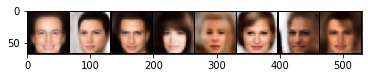

In [106]:
npimg = grid_x_hat.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')